
# Description

This notebook analyzes Airbnb data across different cities, calculating metrics such as listing density, area, and population density. The analysis is based on data files organized by city, containing CSVs with detailed Airbnb listings, pricing, and review information. The results are displayed in both tabular and graphical formats

## Dependencies

**Dependencies** : Install them if they are not already available, the process is as it follows:

1. Create a virtual environvent, by typing in your terminal the following commands:
    
    ```
        python -m venv .venv  
        .\.venv\Scripts\Activate.ps1
    ```
    
2. Installing the dependencies, using the following command:
    
    ```
        python pip install pandas numpy matplotlib shapely pyproj folium seaborn IPython ipywidgets
    ``` 

    also there is `requirements.txt` with the available dependencies and you can install them.


### The Dependencies

- **pandas**: For handling tabular data (CSV import/export, cleaning, grouping, merging).
- **numpy**: For efficient numerical operations (arrays, math functions, statistical calculations).
- **matplotlib**: For creating static plots (bar charts, histograms, visual summaries).
- **shapely**: For geometric operations (polygons, convex hulls, area calculations).
- **pyproj**: For coordinate transformations and projections (e.g., converting WGS84 lat/lon to UTM for area calculation).
- **folium**: For interactive maps (visualizing listings, city boundaries, and spatial data in notebooks).
- **seaborn**: For statistical data visualization with better styling (heatmaps, distributions, pair plots).
- **IPython**: Provides enhanced interactive environment (rich display, pretty print, integration in Jupyter notebooks).
- **ipywidgets**: For interactive UI controls inside Jupyter (dropdowns, sliders, filters to explore data dynamically).



In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from datetime import datetime, timedelta
from IPython.display import display, HTML
import ipywidgets as widgets
import textwrap
from shapely.geometry import Polygon
from shapely.ops import transform
import pyproj

## Data Structures

Below there are some structures one list and three dictionaries, the list contains the names of the city's of whom the data will be analyzed, as far as the dictionaries,
below there will a more detailed description:

- city_area_sq_km : Dictionary storing the area of the cities in squared kilometers
- cities_population : Dictionary storing the population of the cities
- city_espg_codes : Dictionary storing the espg codes of the cities

These structures will be helpful for us later on!

In [12]:


#Defining a list with needed cities
cities_list=["Amsterdam","Athens","Barcelona","Berlin","Copenhagen","Dublin","Lisbon","London","Madrid","Paris","Rome","Venice","Vienna"]
print("Current Working Directory:", os.getcwd())
os.chdir(os.path.dirname(os.path.abspath("__file__")))
print("New Working Directory:", os.getcwd())

directory_location="./airbnb_data/"
reviews_directory = './airbnb_reviews_data/'

column_counts = {} #Dictionary used to store counts for ciy listings

listings_sum=0 #Variable used in later function

#Dictionary storing the area of the cities in squared kilometers 
city_areas_sq_km = [
    {"city": "Amsterdam", "area_km2": 219},
    {"city": "Athens", "area_km2": 39},
    {"city": "Barcelona", "area_km2": 101},
    {"city": "Berlin", "area_km2": 891},
    {"city": "Copenhagen", "area_km2": 86},
    {"city": "Dublin", "area_km2": 117},
    {"city": "Lisbon", "area_km2": 100},
    {"city": "London", "area_km2": 1572},
    {"city": "Madrid", "area_km2": 604},
    {"city": "Paris", "area_km2": 105},
    {"city": "Rome", "area_km2": 1285},
    {"city": "Venice", "area_km2": 414},
    {"city": "Vienna", "area_km2": 414}
]

#Dictionary storing the population of the cities 
cities_populations = [
    {"city": "Amsterdam", "population": 1182000},
    {"city": "Athens", "population": 3155000},
    {"city": "Barcelona", "population": 5712000},
    {"city": "Berlin", "population": 3577000},
    {"city": "Copenhagen", "population": 1391000},
    {"city": "Dublin", "population": 1285000},
    {"city": "Lisbon", "population": 3015000},
    {"city": "London", "population": 9748030},
    {"city": "Madrid", "population": 6783240},
    {"city": "Paris", "population": 11277000},
    {"city": "Rome", "population": 4332000},
    {"city": "Venice", "population": 642000},
    {"city": "Vienna", "population": 1990000}
]

#Dictionary storing the espg codes of the cities
city_epsg_codes = [
    {"city": "Amsterdam", "epsg_code": "EPSG:32631"},
    {"city": "Athens", "epsg_code": "EPSG:32634"},
    {"city": "Barcelona", "epsg_code": "EPSG:32631"},
    {"city": "Berlin", "epsg_code": "EPSG:32633"},
    {"city": "Copenhagen", "epsg_code": "EPSG:32633"},
    {"city": "Dublin", "epsg_code": "EPSG:32629"},
    {"city": "Lisbon", "epsg_code": "EPSG:32629"},
    {"city": "London", "epsg_code": "EPSG:32630"},
    {"city": "Madrid", "epsg_code": "EPSG:32630"},
    {"city": "Paris", "epsg_code": "EPSG:32631"},
    {"city": "Rome", "epsg_code": "EPSG:32633"},
    {"city": "Venice", "epsg_code": "EPSG:32633"},
    {"city": "Vienna", "epsg_code": "EPSG:32633"}
]

Current Working Directory: c:\Users\gian5\Downloads\Assignment1_8210025
New Working Directory: c:\Users\gian5\Downloads\Assignment1_8210025


# `plot_city_listings` Function Documentation

This function, `plot_city_listings`, calculates the total non-null entries in the first column of each CSV file located within specified city subfolders in a main directory. It outputs a bar plot and a tabular summary showing the total listings count for each city.

## Function Signature

```python

def plot_city_listings(cities, directory):
    
    """
    This function calculates the sum of non-null values in the first column of each CSV file
    in the specified subfolders (cities) within the main directory and returns a plot and table.

    Parameters:
    - cities (list): List of city names, each representing a subfolder.
    - directory (str): Path to the main directory containing city subfolders.

    Returns:
    - A plot of total listings per city and a printed table of results.
    """

```

      City  Total Listings
    London           96182
     Paris           95461
      Rome           32243
    Madrid           26980
    Lisbon           24204
Copenhagen           20909
 Barcelona           19482
    Vienna           14396
    Berlin           13759
    Athens           13274
 Amsterdam            9659
    Venice            8322
    Dublin            6175


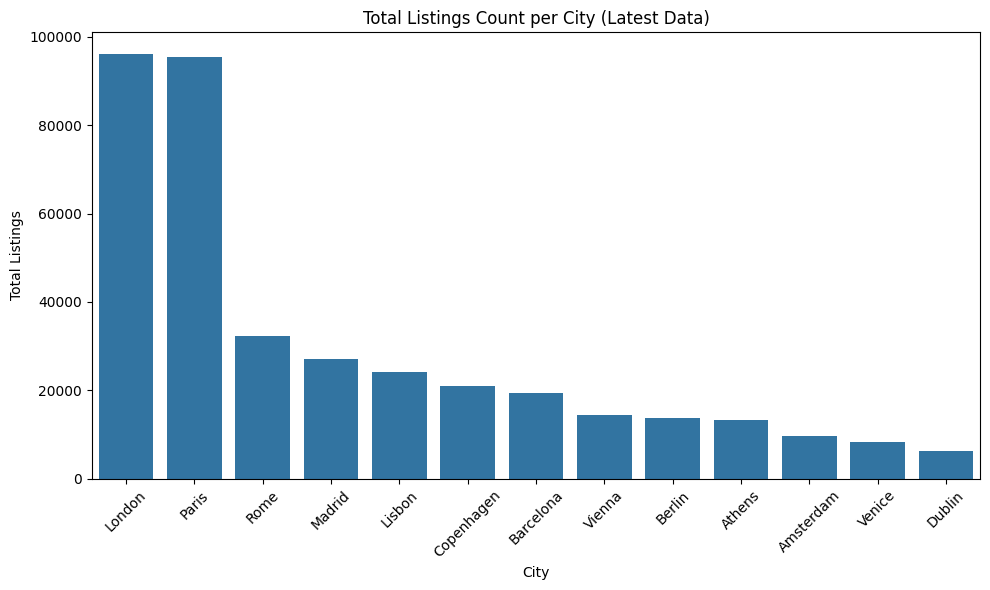

In [23]:
def plot_city_listings(cities, directory):
    """
    Calculate the number of unique Airbnb listings for the latest CSV file
    in each city's folder. Displays results as a table and bar plot.

    Parameters:
    - cities (list): List of city names, each representing a subfolder.
    - directory (str): Path to the main directory containing city subfolders.

    Returns:
    - pd.DataFrame: Table of total listings per city.
    """
    city_data = []

    for city in cities:
        csv_directory = os.path.join(directory, city)

        if not os.path.isdir(csv_directory):
            print(f"Directory {csv_directory} does not exist. Skipping.")
            city_data.append({'City': city, 'Total Listings': 0})
            continue

        # Filter only CSV files
        csv_files = [os.path.join(csv_directory, f) 
                     for f in os.listdir(csv_directory) if f.endswith(".csv")]

        if not csv_files:
            city_data.append({'City': city, 'Total Listings': 0})
            continue

        # Pick the latest CSV (filenames contain date like 'listings-2023-08.csv')
        latest_file = max(csv_files, key=os.path.basename)

        try:
            df = pd.read_csv(latest_file)
            if "id" in df.columns:
                count = df["id"].nunique()
            else:
                count = df.iloc[:, 0].nunique()
        except Exception as e:
            print(f"Error reading {latest_file}: {e}")
            count = 0

        city_data.append({'City': city, 'Total Listings': count})

    # Create results DataFrame
    results_df = pd.DataFrame(city_data).sort_values("Total Listings", ascending=False)

    # Print table
    print(results_df.to_string(index=False))

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x="City", y="Total Listings", data=results_df)
    plt.xticks(rotation=45)
    plt.title("Total Listings Count per City (Latest Data)")
    plt.tight_layout()
    plt.show()

    return results_df


# Run function
listings_df = plot_city_listings(cities_list, directory_location)



| Function | What it does | Parameters | Returns |
|----------|--------------|------------|---------|
| **`get_city_area(city_name, city_areas_sq_km)`** | Finds the area of a city in square kilometers. | - `city_name` (str): City name<br>- `city_areas_sq_km` (list/dict sequence): City names with areas | `float` area in km² if found, else `None` |
| **`get_city_epsg_code(city_name, city_epsg_codes)`** | Retrieves the EPSG projection code for a city. | - `city_name` (str): City name<br>- `city_epsg_codes` (list/dict sequence, optional): City names with EPSG codes | `str` EPSG code like `"EPSG:32634"` if found, else `None` |
| **`get_city_population(city_name, cities_populations)`** | Gets the population of a city. | - `city_name` (str): City name<br>- `cities_populations` (list/dict sequence): City names with populations | `int` population if found, else `None` |
| **`get_city_density(city_name, city_areas_sq_km, cities_populations)`** | Calculates population density for a city. | - `city_name` (str): City name<br>- `city_areas_sq_km` (list/dict sequence): Areas<br>- `cities_populations` (list/dict sequence): Populations | `float` density (pop/km²) if valid, else `None` |
| **`merge_csv_files(file_list)`** | Reads multiple CSVs and merges them into one DataFrame. | - `file_list` (list of str/path): Paths to CSV files | `pandas.DataFrame` merged; empty if none could be read |
| **`extract_latitude_longitude(df)`** | Extracts latitude/longitude columns, cleans them. | - `df` (`pandas.DataFrame`): Input with lat/lon columns | DataFrame with cleaned `latitude` and `longitude`, else empty DataFrame |
| **`_compute_utm_epsg_from_lon_lat(lon, lat)`** | Determines correct UTM EPSG code from coordinates. | - `lon` (float): Longitude<br>- `lat` (float): Latitude | `str` EPSG code (`EPSG:326xx` or `EPSG:327xx`) |
| **`_convex_hull_polygon(points_lon_lat)`** | Builds convex hull polygon from (lon, lat) points. | - `points_lon_lat` (iterable of tuples): Coordinates | `shapely.Polygon` if ≥3 points, else `None` |



### My `listing_density_per_1000_inhabitants` Function

I created the `listing_density_per_1000_inhabitants` function to calculate the density of Airbnb listings per 1000 inhabitants across a list of cities. This function combines data from multiple CSV files within a specified directory, calculates area and population metrics, and presents the results both in a table and a bar plot for easy visualization.

#### Function Signature

```python
def listing_density_per_1000_inhabitants(cities, directory)
```
## How It Works

1. **Initialize Results List**:  
   I start by creating an empty list called `cities_listing_density` to store results for each city.

2. **Process Each City**:
   - **Check City Directory**:  
     For each city, I check if its subfolder exists in the directory. If the folder is missing, I print a warning, add a null density value, and skip to the next city.

   - **Load CSV Files**:  
     I then read all CSV files in the city’s directory, merging them into a single DataFrame.

   - **Extract Unique Coordinates**:  
     Using the `extract_latitude_longitude` function, I get unique latitude and longitude points that help define the city boundary for area calculation.

   - **Calculate Area**:  
     I call `calculate_area_from_lat_long` to compute the city’s area based on the unique coordinates.

   - **Fetch Population and Density**:  
     I retrieve the city’s population using `get_city_population` and calculate density using `get_city_density`.

   - **Compute Listings Density**:  
     Finally, I calculate the density of Airbnb listings per 1000 inhabitants.

3. **Display Results**:  
   I convert `cities_listing_density` into a DataFrame, print it, and create a bar plot to show each city’s listing density per 1000 inhabitants.


      City  Density per 1000
 Amsterdam          8.254942
    Athens          2.456393
 Barcelona          2.823141
    Berlin          1.871186
Copenhagen         20.307680
    Dublin          2.119318
    Lisbon          0.040347
    London          4.700026
    Madrid         12.545574
     Paris          2.923022
      Rome          9.573069
    Venice          8.593935
    Vienna         22.023897


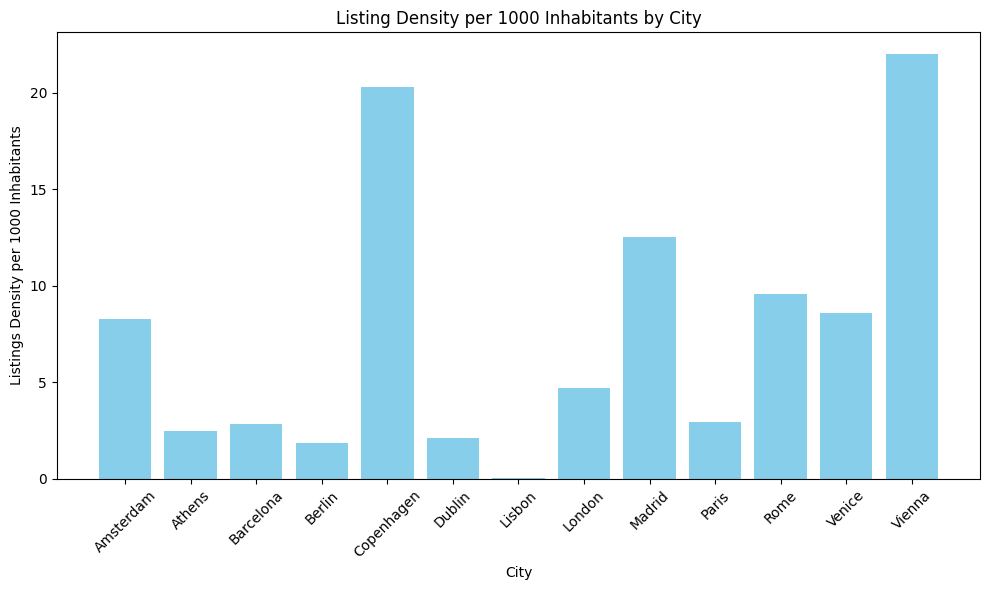

In [25]:

#Function returning value from city_areas_sq_value dictionary
def get_city_area(city_name):
    for city_info in city_areas_sq_km:
        if city_info["city"].lower() == city_name.lower():
            return city_info["area_km2"]
    return None

#Function returning value from city_espg_codes dictionary
def get_city_espg_code(city_name):
    for city_info in city_epsg_codes:
        if city_info["city"].lower() == city_name.lower():
            return city_info["epsg_code"]
    return None
#Function returning value from cities_population dictionary
def get_city_population(city_name):
    for city_info in cities_populations:
        if city_info["city"].lower() == city_name.lower():
            return city_info["population"]
    return None

def extract_latitude_longitude(df_default):
    if 'id' in df_default.columns and 'latitude' in df_default.columns and 'longitude' in df_default.columns:
        return df_default[['id', 'latitude', 'longitude']].copy()
    else:
        print("Error: Required columns are missing.")
        return pd.DataFrame(columns=['id', 'latitude', 'longitude'])

def merge_csv_files(file_list):
    df_list = [pd.read_csv(file) for file in file_list]
    merged_df = pd.concat(df_list, ignore_index=True)
    return merged_df

def load_and_merge_city_data(city, directory):
    """
    Load the latest Airbnb listings CSV for a given city.

    Parameters:
    - city (str): City name
    - directory (str): Path to airbnb_data folder

    Returns:
    - pd.DataFrame: Cleaned DataFrame with all listings for that city
    """
    import os
    import pandas as pd

    city_path = os.path.join(directory, city)
    if not os.path.isdir(city_path):
        raise FileNotFoundError(f"City directory not found: {city_path}")

    # Get all CSV files in the folder
    csv_files = [os.path.join(city_path, f) for f in os.listdir(city_path) if f.endswith(".csv")]
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found for {city} in {city_path}")

    # Pick the latest file by filename (they usually contain dates)
    latest_file = max(csv_files, key=os.path.basename)

    # Load the CSV
    df = pd.read_csv(latest_file)

    # Ensure important columns exist
    required_cols = ["id", "host_id", "room_type", "minimum_nights", "latitude", "longitude", "price", "number_of_reviews_ltm"]
    for col in required_cols:
        if col not in df.columns:
            print(f"Warning: Column '{col}' not found in {latest_file}")

    # Compute total nights for occupancy analysis
    if "number_of_reviews_ltm" in df.columns and "price" in df.columns:
        df["bookings"] = df["number_of_reviews_ltm"] * 2
        df["total_nights"] = df["bookings"] * 3
        df["income_estimate"] = df["bookings"] * df["price"]

    return df

def calculate_area_from_lat_long(unique_lat_long, city_name):
    boundary_points = list(zip(unique_lat_long['longitude'], unique_lat_long['latitude']))
    polygon = Polygon(boundary_points)

    epsg_code = get_city_espg_code(city_name)
    if epsg_code is None:
        print(f"EPSG code for {city_name} not found.")
        return None

    wgs84 = pyproj.CRS("EPSG:4326")
    utm_projection = pyproj.CRS(epsg_code)
    project = pyproj.Transformer.from_crs(wgs84, utm_projection, always_xy=True).transform
    projected_polygon = transform(project, polygon)
    area_sq_km = projected_polygon.area / 1e6
    return area_sq_km

def get_city_density(city_name, city_areas, city_populations):
    area_info = next((item for item in city_areas if item["city"].lower() == city_name.lower()), None)
    population_info = next((item for item in city_populations if item["city"].lower() == city_name.lower()), None)
    
    if area_info and population_info:
        area_km2 = area_info["area_km2"]
        population = population_info["population"]
        return population / area_km2
    else:
        print(f"Data for {city_name} is missing.")
        return None

def listing_density_per_1000_inhabitants(cities, directory):
    cities_listing_density = []

    for city in cities:
        csv_directory = os.path.join(directory, city)
        if not os.path.isdir(csv_directory):
            print(f"Directory {csv_directory} does not exist. Skipping {city}.")
            cities_listing_density.append({'City': city, 'Density per 1000': None})
            continue

        csv_files_for_density = [os.path.join(csv_directory, file) for file in os.listdir(csv_directory) if file.endswith('.csv')]
        df_listings = merge_csv_files(csv_files_for_density)
        unique_lat_long = extract_latitude_longitude(df_listings)[['latitude', 'longitude']].drop_duplicates()

        sq_km = calculate_area_from_lat_long(unique_lat_long, city)
        city_population = get_city_population(city)
        city_density = get_city_density(city, city_areas_sq_km, cities_populations)

        if city_density and sq_km:
            airbnb_population = sq_km * city_density
            total_listings = len(unique_lat_long)
            density_per_1000 = (total_listings / airbnb_population) * 1000 if airbnb_population > 0 else 0
            cities_listing_density.append({'City': city, 'Density per 1000': density_per_1000})
        else:
            print(f"Skipping {city} due to missing area/population data.")
            cities_listing_density.append({'City': city, 'Density per 1000': None})

    # Convert to DataFrame for display
    density_df = pd.DataFrame(cities_listing_density)
    print(density_df.to_string(index=False))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(density_df['City'], density_df['Density per 1000'], color='skyblue')
    plt.xlabel('City')
    plt.ylabel('Listings Density per 1000 Inhabitants')
    plt.title('Listing Density per 1000 Inhabitants by City')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

listing_density_per_1000_inhabitants(cities_list, directory_location)

      City  Total Listings  Population  Listings per 1000
Copenhagen           20909     1391000          15.031632
    Venice            8322      642000          12.962617
    London           96182     9748030           9.866814
     Paris           95461    11277000           8.465106
 Amsterdam            9659     1182000           8.171743
    Lisbon           24204     3015000           8.027861
      Rome           32243     4332000           7.442982
    Vienna           14396     1990000           7.234171
    Dublin            6175     1285000           4.805447
    Athens           13274     3155000           4.207290
    Madrid           26980     6783240           3.977450
    Berlin           13759     3577000           3.846519
 Barcelona           19482     5712000           3.410714


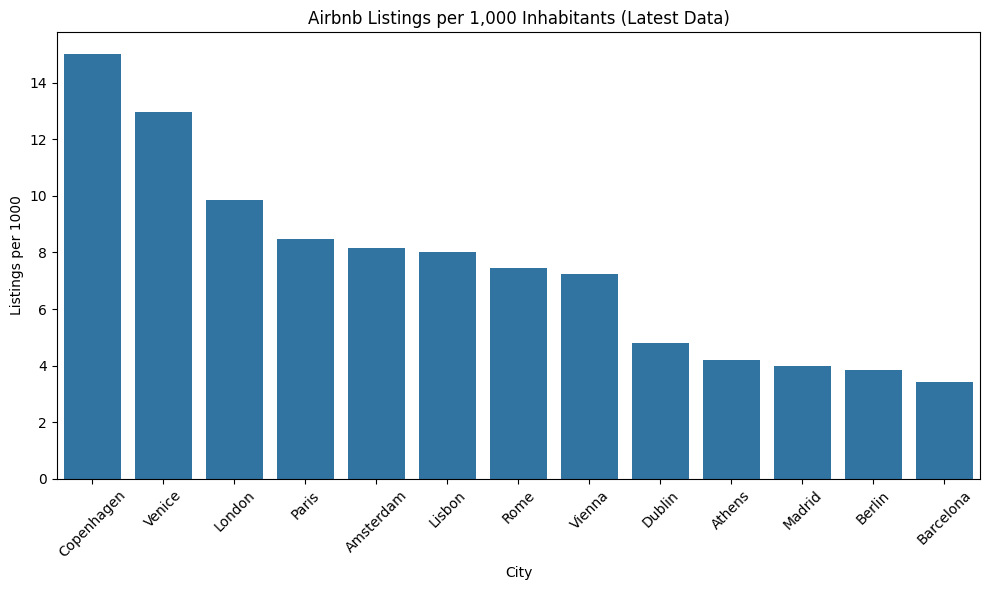

In [24]:
def listing_density_per_1000_inhabitants(cities, directory):
    """
    Calculate Airbnb listings per 1,000 inhabitants for each city
    using the latest CSV file in each city's folder.

    Parameters:
    - cities (list): List of city names
    - directory (str): Path to main data folder

    Returns:
    - pd.DataFrame with city, listings, population, density per 1000
    """
    city_data = []

    for city in cities:
        csv_directory = os.path.join(directory, city)
        if not os.path.isdir(csv_directory):
            print(f"Directory {csv_directory} does not exist. Skipping {city}.")
            continue

        csv_files = [os.path.join(csv_directory, f) 
                     for f in os.listdir(csv_directory) if f.endswith(".csv")]
        if not csv_files:
            continue

        # pick latest file (filenames contain date)
        latest_file = max(csv_files, key=os.path.basename)

        try:
            df = pd.read_csv(latest_file)
            if "id" in df.columns:
                total_listings = df["id"].nunique()
            else:
                total_listings = df.iloc[:, 0].nunique()
        except Exception as e:
            print(f"Error reading {latest_file}: {e}")
            total_listings = 0

        population = get_city_population(city)

        density_per_1000 = (total_listings / population) * 1000 if population else None

        city_data.append({
            "City": city,
            "Total Listings": total_listings,
            "Population": population,
            "Listings per 1000": density_per_1000
        })

    # results
    results_df = pd.DataFrame(city_data).sort_values("Listings per 1000", ascending=False)

    print(results_df.to_string(index=False))

    plt.figure(figsize=(10, 6))
    sns.barplot(x="City", y="Listings per 1000", data=results_df)
    plt.xticks(rotation=45)
    plt.title("Airbnb Listings per 1,000 Inhabitants (Latest Data)")
    plt.tight_layout()
    plt.show()

    return results_df


# Run
density_df = listing_density_per_1000_inhabitants(cities_list, directory_location)


# Documentation for Airbnb Data Analysis Functions

This set of functions is designed to analyze Airbnb data, including merging CSV files, filtering review data by date, extracting listing prices, counting reviews per listing, and calculating averages and total metrics for each city. These utilities streamline the process of analyzing Airbnb data across multiple cities.

---

## Helper Functions

### 1. `merge_csv_files`

Merges multiple CSV files into a single DataFrame.

```python
def merge_csv_files(file_list)
```
Parameters:
- `file_list` (list of str): A list of file paths to CSV files to be merged.
A merged DataFrame containing data from all the provided CSV files.

### 2. `load_and_merge_city_data`

Loads all CSV files from a specified city’s directory, merges them, and returns a single DataFrame.
```python
def load_and_merge_city_data(city, directory)
```
Parameters
- `city` (str): The name of the city, used to locate the appropriate subfolder within the directory.
- `directory` (str): The main directory containing subfolders for each city.

### 3. `filter_reviews_last_year`

Filters reviews in a DataFrame to include only those from the last year based on a specified date column.
```python
def filter_reviews_last_year(df_reviews, date_column='review_date')
```
Parameters
- `df_reviews` (DataFrame): The DataFrame containing review data.
- `date_column` (str): The name of the column containing review dates (default: `"review_date").

### 4. `extract_listing_price`

Extracts listing price information by selecting `id` and `price` columns from a DataFrame and renaming `id` to `listing_id`.
```python
def extract_listing_price(df_prices)
```
Parameters:
- `df_prices` (DataFrame): The DataFrame containing price data for listings.
```
Returns:
A DataFrame with `listing_id` and `price` columns. Returns an empty DataFrame if the required columns are missing.

### 5. `count_reviews_per_listing`

Counts the number of reviews per listing in a DataFrame and returns the results.
```python
def count_reviews_per_listing(df_reviews)
```
Parameters:
- `df_reviews` (DataFrame): The DataFrame containing review data, including a `listing_id` column.

Returns:
A DataFrame with `listing_id` and `review_count` columns. Returns an empty DataFrame if the `listing_id` column is missing.

### 6. `find_averages`

Calculates average metrics for each city, including average nights booked and average income per listing. This function processes price and review data for each city, calculates estimated bookings, total nights, and income per listing.

``` python
def find_averages(price_directory, review_directory, cities)
```
Parameters:
- `price_directory` (str): The directory containing CSV files with price data for listings.
- `review_directory` (str): The directory containing CSV files with review data.
- `cities` (list of str): A list of city names to process.

Returns:
A dictionary where each key is a city name and each value is a dictionary with the following keys:
- `avg_nights`: The average nights booked per listing.
- `avg_income`: The average income per listing.
- `data`: A merged DataFrame for each listing with calculated metrics such as `estimated_bookings`, `total_nights`, and `income_per_listing`.

In [ ]:

# Visualization functions
def create_map_of_listings(df_city, city):
    
    ##A dictionary of aech city's coordinates
    city_coordinates = {
        "Amsterdam": [52.3676, 4.9041],
        "Athens": [37.9838, 23.7275],
        "Barcelona": [41.3851, 2.1734],
        "Berlin": [52.5200, 13.4050],
        "Copenhagen": [55.6761, 12.5683],
        "Dublin": [53.3498, -6.2603],
        "Lisbon": [38.7169, -9.1399],
        "London": [51.5074, -0.1278],
        "Madrid": [40.4168, -3.7038],
        "Paris": [48.8566, 2.3522],
        "Rome": [41.9028, 12.4964],
        "Venice": [45.4408, 12.3155],
        "Vienna": [48.2082, 16.3738]
    }
    
    location = city_coordinates.get(city, [37.9838, 23.7275])
    map_city = folium.Map(location=location, zoom_start=12)
    color_map = {
        "Entire home/apt": "red",
        "Private room": "blue",
        "Shared room": "green",
        "Hotel room": "purple"
    }

    for _, row in df_city.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=3,
            color=color_map.get(row['room_type'], 'black'),
            fill=True,
            fill_color=color_map.get(row['room_type'], 'black'),
            fill_opacity=0.6
        ).add_to(map_city)

    map_file = f"{city}_map.html"
    map_city.save(map_file)
    display(HTML(f'<iframe src="{map_file}" width="600" height="400"></iframe>'))

### `create_map_of_listings`

Creates an interactive map of Airbnb listings for a specified city. The map uses color-coded markers based on the type of room.

```python
def create_map_of_listings(df_city, city)
```
Parameters:
- `df_city` (DataFrame): A DataFrame containing Airbnb listing data for a city. Must include `latitude`, `longitude`, and `room_type` columns.
- `city` (str): The name of the city to generate the map for. If the city is not in the predefined list, it defaults to Athens.

Returns:
An HTML file (`<city>_map.html`) that displays an interactive map with markers for each listing. Color codes are used to distinguish room types:
- Red: Entire home/apt
- Blue: Private room
- Green: Shared room
- Purple: Hotel room
```

In [17]:
def plot_occupancy_histogram(df_city):
    plt.figure(figsize=(6, 4))
    plt.hist(df_city['total_nights'], bins=[0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365], color='skyblue', edgecolor='black')
    plt.xlabel('Occupancy (last 12 months)')
    plt.ylabel('Listings')
    plt.title('Occupancy (last 12 months)')
    plt.xticks(rotation=45)
    plt.show()

def plot_room_type_distribution(df_city):
    room_type_counts = df_city['room_type'].value_counts()
    plt.figure(figsize=(6, 4))
    sns.barplot(x=room_type_counts.values, y=room_type_counts.index, palette="pastel")
    plt.xlabel('Listings')
    plt.ylabel('Room Type')
    plt.title('Room Type Distribution')
    plt.show()


### `plot_occupancy_histogram`

Plots a histogram showing the distribution of occupancy (in terms of nights booked) for Airbnb listings in the last 12 months.

def plot_occupancy_histogram(df_city)

Parameters:
- `df_city` (DataFrame): A DataFrame containing Airbnb listing data for a city, with a `total_nights` column representing the total number of nights booked in the last 12 months.

Returns:
Displays a histogram plot showing the distribution of occupancy over defined intervals (0–365 days).

### `plot_room_type_distribution`

Plots a bar chart showing the distribution of Airbnb listings by room type (e.g., Entire home/apt, Private room, etc.).

def plot_room_type_distribution(df_city)

Parameters:
- `df_city` (DataFrame): A DataFrame containing Airbnb listing data for a city, including a `room_type` column that indicates the type of each listing (e.g., Entire home/apt, Private room, Shared room).

Returns:
Displays a bar chart showing the count of listings for each room type.

In [18]:
def plot_license_distribution(df_city):
    # Ensure the 'license' column exists
    if 'license' not in df_city.columns:
        print("Error: The 'license' column does not exist in the data.")
        return

    # Handle missing values by replacing them with "Unknown"
    df_city['license'] = df_city['license'].fillna("Unknown")
    
    # Get the value counts for each license status
    license_counts = df_city['license'].value_counts()
    
    # Group small categories into 'Other' if there are too many unique values
    if len(license_counts) > 5:
        license_counts = license_counts.nlargest(4)  # Keep top 4
        license_counts['Other'] = df_city['license'].value_counts()[4:].sum()  # Group remaining as 'Other'

    # Labels and sizes for the pie chart
    license_labels = [label[:8] + "..." if len(label) > 8 else label for label in license_counts.index]  # Shorten long labels
    license_sizes = license_counts.values
    
    # Plot the pie chart with percentages only
    plt.figure(figsize=(5, 5))
    wedges, texts, autotexts = plt.pie(
        license_sizes,
        labels=[''] * len(license_labels),  # Empty labels on the chart itself
        autopct='%1.0f%%',
        startangle=140,
        colors=sns.color_palette("Set2", len(license_labels)),
        explode=[0.05] * len(license_labels)  # Slightly explode all slices
    )
    
    # Adjust percentage text properties for better readability
    for autotext in autotexts:
        autotext.set_color('black')  # Change percentage text color for better contrast
        autotext.set_fontsize(10)    # Increase font size
        autotext.set_fontweight('bold')  # Make text bold for clarity
    
    # Add legend with full labels
    plt.legend(wedges, license_labels, title="License Status", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=8)
    plt.title("Licenses")
    plt.show()

### `plot_license_distribution`

Plots a pie chart showing the distribution of Airbnb listings by license status. If the `license` column has many unique values, only the top 4 are shown individually, with the rest grouped as "Other".

def plot_license_distribution(df_city)

Parameters:
- `df_city` (DataFrame): A DataFrame containing Airbnb listing data for a city. Must include a `license` column to display license information for each listing.

Returns:
Displays a pie chart showing the distribution of listings by license status. If there are more than 5 unique license statuses, only the top 4 are shown, with others grouped as "Other".

In [19]:
def plot_minimum_nights_distribution(df_city):
    plt.figure(figsize=(6, 4))
    sns.histplot(df_city['minimum_nights'], bins=range(1, 36), kde=False, color='skyblue')
    plt.xlabel("Minimum Nights")
    plt.ylabel("Listings")
    plt.title("Short-Term Rentals")
    plt.xticks(range(1, 36, 5))
    plt.show()


### `plot_minimum_nights_distribution`

Plots a histogram showing the distribution of minimum nights required for Airbnb listings, highlighting short-term rental options.

def plot_minimum_nights_distribution(df_city)

Parameters:
- `df_city` (DataFrame): A DataFrame containing Airbnb listing data for a city, with a `minimum_nights` column representing the minimum nights required for each listing.

Returns:
Displays a histogram plot showing the distribution of listings by minimum nights required, with bins ranging from 1 to 35 nights.

In [20]:
# Function to plot the distribution of listings per host
def plot_listings_per_host(df_city):
    # Group by host and count listings
    listings_per_host = df_city.groupby('host_id').size()
    
    # Count single vs. multi-listings
    single_listing_count = (listings_per_host == 1).sum()
    multi_listing_count = (listings_per_host > 1).sum()
    total_listings = single_listing_count + multi_listing_count
    multi_listing_percentage = (multi_listing_count / total_listings) * 100
    single_listing_percentage = (single_listing_count / total_listings) * 100

    # Plot the histogram
    plt.figure(figsize=(8, 4))
    sns.histplot(listings_per_host, bins=range(1, 12), color='skyblue', edgecolor='black')
    plt.xlabel('Listings per Host')
    plt.ylabel('Listings')
    plt.title('Listings per Host')
    plt.xticks(list(range(1, 11)) + [10], labels=[str(i) for i in range(1, 11)] + ['10+'])  # Convert range to list
    plt.show()

    # Display percentages of single and multi-listings
    print(f"Single Listings: {single_listing_count} ({single_listing_percentage:.1f}%)")
    print(f"Multi-Listings: {multi_listing_count} ({multi_listing_percentage:.1f}%)")


### `plot_listings_per_host`

Plots a histogram showing the distribution of listings per host for Airbnb data, and displays the percentage of single-listing and multi-listing hosts.


def plot_listings_per_host(df_city)

Parameters:
- `df_city` (DataFrame): A DataFrame containing Airbnb listing data for a city, with a `host_id` column representing the host ID for each listing.

Returns:
Displays a histogram plot showing the number of listings per host. Also prints the count and percentage of hosts with a single listing versus multiple listings.

In [21]:
# Function to display a table of top hosts
def display_top_hosts(df_city, top_n=10):
    # Group by host to count listings of each type
    host_counts = df_city.groupby(['host_id', 'room_type']).size().unstack(fill_value=0)
    
    # Calculate total listings per host
    host_counts['Total Listings'] = host_counts.sum(axis=1)
    
    # Sort by total listings and select top hosts
    top_hosts = host_counts.nlargest(top_n, 'Total Listings')
    top_hosts.reset_index(inplace=True)

    # Rename columns for better readability
    top_hosts.columns = ['Host Name', 'Entire home/apt', 'Private room', 'Shared room', 'Hotel room', 'Total Listings']

    # Display the table
    print("\nTop Hosts")
    display(top_hosts)

### `display_top_hosts`

Displays a table of the top hosts with the highest number of listings, including a breakdown by room type.

```python
def display_top_hosts(df_city, top_n=10)
```

Parameters:
- `df_city` (DataFrame): A DataFrame containing Airbnb listing data for a city, with `host_id` and `room_type` columns.
- `top_n` (int, optional): The number of top hosts to display (default: 10).

Returns:
Displays a table with the top hosts by total listings, including columns for each room type and a total listing count per host.


In [ ]:
# Integrate these functions into the main display function
def display_city_visualizations(city, directory):
    df_city = load_and_merge_city_data(city, directory)
    
    
    create_map_of_listings(df_city, city)

    print("\nRoom Type Distribution:")
    plot_room_type_distribution(df_city)
    
    
    print("\nOccupancy Histogram:")
    plot_occupancy_histogram(city_averages[city]['data'])    
   
    print("\nLicense Distribution:")
    plot_license_distribution(df_city)
    
    print("\nMinimum Nights Distribution:")
    plot_minimum_nights_distribution(df_city)
    
    # New plots
    print("\nListings per Host:")
    plot_listings_per_host(df_city)
    
    print("\nTop Hosts:")
    display_top_hosts(df_city)

# Interactive selection
city_selector = widgets.Dropdown(options=cities_list, description='Select City:')
widgets.interactive(display_city_visualizations, city=city_selector, directory=widgets.fixed(directory_location))

interactive(children=(Dropdown(description='Select City:', options=('Amsterdam', 'Athens', 'Barcelona', 'Berli…

### `display_city_visualizations`

Generates and displays multiple visualizations for Airbnb data of a specified city, including maps and distributions of room types, occupancy, license statuses, minimum nights, listings per host, and top hosts by total listings.

```python
def display_city_visualizations(city, directory)
```

Parameters:
- `city` (str): The name of the city for which to display visualizations.
- `directory` (str): The main directory containing subfolders with data files for each city.

Returns:
Displays a series of visualizations and tables:
- Map of Airbnb listings in the selected city.
- Room type distribution bar chart.
- Occupancy histogram (last 12 months).
- License distribution pie chart.
- Minimum nights distribution histogram.
- Listings per host histogram with single vs. multi-listing percentages.
- Table of top hosts by total listings, broken down by room type.

Interactive Selection:
Allows users to select a city from `cities_list` using a dropdown widget and calls the `display_city_visualizations` function with the chosen city and fixed directory location.

### Function Documentation for total bookings and nights 

| Function | What it does | Parameters | Returns |
|----------|--------------|------------|---------|
| **`merge_csv_files(file_list)`** | Merges multiple CSV files into a single DataFrame. | - `file_list` (list of str/path): Paths to CSV files | `pandas.DataFrame` containing merged CSV contents |
| **`filter_reviews_last_year(df_reviews, date_column='review_date')`** | Filters reviews to include only those from the last 365 days. | - `df_reviews` (`pandas.DataFrame`): Reviews data<br>- `date_column` (str): Column with review dates (default: `'review_date'`) | `pandas.DataFrame` with only reviews from last 12 months |
| **`count_reviews_per_listing(df_reviews)`** | Counts the number of reviews per listing. | - `df_reviews` (`pandas.DataFrame`): Reviews data with a `listing_id` column | DataFrame with columns `listing_id` and `review_count`; empty DataFrame if `listing_id` missing |
| **`find_total_bookings_and_nights(review_directory, cities)`** | Processes review CSVs per city to estimate total bookings and nights. Uses assumptions: half of bookings get reviews, each booking = 3 nights. | - `review_directory` (str/path): Directory containing city review subfolders<br>- `cities` (list of str): City names | None (prints results per city to console: total bookings and total nights) |


In [ ]:
def merge_csv_files(file_list):
    """
    Merges multiple CSV files into a single DataFrame.
    """
    df_list = [pd.read_csv(file) for file in file_list]
    merged_df = pd.concat(df_list, ignore_index=True)
    return merged_df

def filter_reviews_last_year(df_reviews, date_column='review_date'):
    """
    Filters reviews to include only those from the last year.
    """
    df_reviews[date_column] = pd.to_datetime(df_reviews[date_column], errors='coerce')
    one_year_ago = datetime.now() - timedelta(days=365)
    df_last_year_reviews = df_reviews[df_reviews[date_column] >= one_year_ago]
    return df_last_year_reviews

def count_reviews_per_listing(df_reviews):
    """
    Counts reviews per listing.
    """
    if 'listing_id' in df_reviews.columns:
        review_counts = df_reviews.groupby('listing_id').size().reset_index(name='review_count')
        return review_counts
    else:
        print("Error: df_reviews must contain 'listing_id' column.")
        return pd.DataFrame(columns=['listing_id', 'review_count'])

def find_total_bookings_and_nights(review_directory, cities):
    """
    Processes review data to calculate total bookings and nights for each city.
    """
    for city in cities:
        # Load and merge review data for the city
        csv_directory_for_reviews = os.path.join(review_directory, city)
        csv_files_for_reviews = [os.path.join(csv_directory_for_reviews, file) for file in os.listdir(csv_directory_for_reviews) if file.endswith('.csv')]
        df_reviews = merge_csv_files(csv_files_for_reviews)

        # Filter reviews from the last year
        reviews_last_12_months = filter_reviews_last_year(df_reviews, date_column="date")

        # Count reviews per listing
        reviews_count = count_reviews_per_listing(reviews_last_12_months)

        # Calculate estimated bookings and total nights per listing
        reviews_count['estimated_bookings'] = reviews_count['review_count'] / 2  # Assuming half of bookings have reviews
        reviews_count['total_nights'] = reviews_count['estimated_bookings'] * 3  # Assuming each booking is 3 nights

        # Calculate city-wide totals
        total_bookings = reviews_count['estimated_bookings'].sum()
        total_nights = reviews_count['total_nights'].sum()

        # Print city results
        print(f"City: {city}")
        print(f"Total Bookings: {total_bookings}")
        print(f"Total Nights: {total_nights}\n")

find_total_bookings_and_nights(reviews_directory,cities_list)

City: Amsterdam
Total Bookings: 74639.0
Total Nights: 223917.0

City: Athens
Total Bookings: 80272.0
Total Nights: 240816.0

City: Barcelona
Total Bookings: 204703.5
Total Nights: 614110.5

City: Berlin
Total Bookings: 58755.0
Total Nights: 176265.0

City: Copenhagen
Total Bookings: 45374.0
Total Nights: 136122.0

City: Dublin
Total Bookings: 71388.5
Total Nights: 214165.5

City: Lisbon
Total Bookings: 291984.0
Total Nights: 875952.0

City: London
Total Bookings: 489898.5
Total Nights: 1469695.5

City: Madrid
Total Bookings: 356303.5
Total Nights: 1068910.5

City: Paris
Total Bookings: 455141.0
Total Nights: 1365423.0

City: Rome
Total Bookings: 406465.5
Total Nights: 1219396.5

City: Venice
Total Bookings: 118566.5
Total Nights: 355699.5

City: Vienna
Total Bookings: 158882.5
Total Nights: 476647.5

